In [17]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math

df = pd.read_csv('final.csv')
df = df.iloc[:,[3,4]]
df = df.rename(columns={"text": "Review", "rating": "Rating"})

df.drop(df[df["Rating"] == 0].index, inplace = True)
df.drop(df[df["Rating"] == 9].index, inplace = True)
df["Rating"] = df["Rating"].apply(lambda x: math.ceil(x/2) )
df['Review'] = df['Review'].apply(lambda x: re.sub('[@#$%^{}?><&*\d+]', '', x))


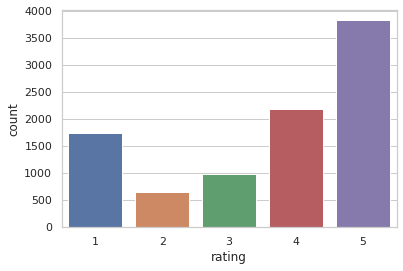

In [18]:
rating_counts = df['Rating'].value_counts()
df_counts = pd.DataFrame({'rating': rating_counts.index, 'count': rating_counts.values})

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="rating", y="count", data=df_counts)

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def remove_stop_words(sentence):
  tokens = word_tokenize(sentence)
  tokens = [tok for tok in tokens if not tok in stop_words]
  for i in tokens:
    i = lemmatizer.lemmatize(i)
  return ' '.join(tokens)

df['Review'] = df['Review'].apply(lambda x: remove_stop_words(x))
print(stop_words)
df['Review']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'y', 'which', 'under', 'each', 'into', 'above', 'very', 'to', 'herself', 'be', "you'll", 'haven', 'shouldn', 'until', 'a', 'through', 'were', 'ourselves', 'being', "mustn't", 'needn', 'does', 'nor', 've', "doesn't", 'so', 'these', 'yours', 'once', 'only', 'will', 'we', 'the', 'most', "you're", 'my', 'against', 'of', 'had', 'then', 'few', 'ours', 'doesn', 'yourselves', 'was', 'while', 'aren', 'her', 'its', 'out', 'hasn', "didn't", 'mightn', 'or', 'at', 'them', 'same', 'before', 'when', 'did', 'm', 'up', 'whom', 'weren', 'with', 'after', "it's", 'this', 'about', 'ain', 'down', 'some', 'do', "shouldn't", 'from', 'during', 'o', 'isn', 'hadn', 'that', 're', 'just', "couldn't", 'are', 'have', 'there', 'don', 'shan', "needn't", 'too', 'himself', "don't", 'here', "wouldn't", "you've", 'won', 'between', 'your', 'll', 'below', 'why', 'our', 'am', 'ma', 'him', 'on', 'their', 'doing', 'again', 'can', 'than', "hadn't", 'own', "that'll", 'is', "you'd", "she's", 'itself', 'not', "hasn't", 'you', 'sh

1        The first time I saw M , Fritz Lang , I almost...
2        The economy , austerity directness films Fritz...
3        M / ( ) '' M '' cinematic masterpiece visual d...
4        Fritz Lang 's highly influential career film d...
5        M monumental film seriously watched . For film...
                               ...                        
12255    I personally loved scary movies - lately creat...
12256    And flick lacks even tragic element thing . I ...
12257    Blockbuster Movies make Hollywood successful b...
12258    You know movies 've seen trailer , 've seen go...
12259    `` Disaster Movie '' horribly unfunny pathetic...
Name: Review, Length: 9393, dtype: object

In [20]:
sentences = []
for line in df['Review']:
    # remove punctuation
    line = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',line).strip()
    # tokenizer
    tokens = re.findall(r'\b\w+\b', line)
    if len(tokens) > 1:
        sentences.append(tokens)

In [44]:
from gensim.models import Word2Vec
bard2vec = Word2Vec(
            sentences,
            min_count=3,   # Ignore words that appear less than this
            size=100,       # Dimensionality of word embeddings
            sg = 1,        # skipgrams
            window=7,      # Context window for words during training
            iter=40)    

In [6]:
pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 974 kB 6.9 MB/s 


In [21]:
from glove import Corpus, Glove # creating a corpus object

# instantiate the corpus
corpus = Corpus() 

# this will create the word co occurence matrix 
corpus.fit(sentences, window=10)

# instantiate the model
glove = Glove(no_components=100, learning_rate=0.05)

# and fit over the corpus matrix
glove.fit(corpus.matrix, epochs=30, no_threads=4)

# finally we add the vocabulary to the model
glove.add_dictionary(corpus.dictionary)


In [22]:
texts = df['Review'].values
ratings = df['Rating'].astype(float).values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(texts, ratings, test_size=0.20, shuffle=True,random_state=2)

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
max_sequence_len = max([len(x) for x in train_sequences])

train_sequences = np.array(pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post'))
test_sequences = np.array(pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post'))

In [24]:

wordtovec = glove.word_vectors
words = list(glove.dictionary.keys())
embeddings = {} 
for i in range(0,len(words)):
    word = words[i];
    coefs = wordtovec[i]
    embeddings[word] = coefs;

word_matrix = []

embeddings_matrix = np.zeros((total_words, 100));
for word, i in word_index.items():
  embedding_vector = embeddings.get(word);
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector;
  else :
    word_matrix.append(word)

word_matrix = list(set(word_matrix))


In [26]:
! pip install -q pyspellchecker

from spellchecker import SpellChecker

     |████████████████████████████████| 2.5 MB 6.5 MB/s 


In [25]:
from pandas.core.groupby import base
import json

#base_path = "/content/"

def get_autocorrections(oov_words):
  spell = SpellChecker()
  auto_corrections = {}

  for word in oov_words:
      # Get the one `most likely` answer
      auto_corrections[word] = spell.correction(word)
      if len(auto_corrections) % 100 == 0:
        print(f'corrected: {len(auto_corrections)} words from a total of {len(oov_words)}')
  
  with open(os.path.join('oov_words.json'), 'w') as json_file:
    json.dump(auto_corrections, json_file)

auto_corrections = get_autocorrections(word_matrix)

NameError: ignored

In [60]:
def load_autocorrections_from_json():
  with open('oov_words.json') as json_file:
    return json.load(json_file)

auto_corrections = load_autocorrections_from_json()

for oov_word, correction in auto_corrections.items():
  embedding_vector = embeddings.get(correction);
  if embedding_vector is not None:
    embeddings_matrix[word_index[oov_word]] = embedding_vector



In [61]:
max_sequence_len

1025

In [27]:

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_model(total_words, embedding_dim, input_length, embeddings_matrix):
  model = Sequential([
  tf.keras.layers.Embedding(total_words, embedding_dim, input_length=input_length, weights=[embeddings_matrix], trainable=False),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])
  model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['mae'])
  return model

model = build_model(total_words, 100, max_sequence_len, embeddings_matrix)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1025, 100)         4912200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

In [13]:

!pip install -q livelossplot
from livelossplot import PlotLossesKeras

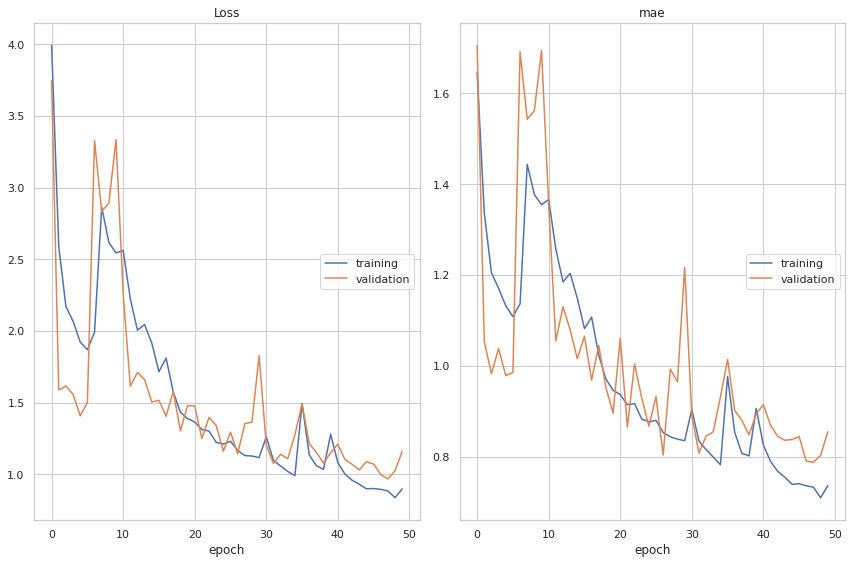

Loss
	training         	 (min:    0.838, max:    3.991, cur:    0.900)
	validation       	 (min:    0.969, max:    3.745, cur:    1.162)
mae
	training         	 (min:    0.709, max:    1.647, cur:    0.736)
	validation       	 (min:    0.788, max:    1.705, cur:    0.854)
224/224 [==============================] - 196s 874ms/step - loss: 0.8997 - mae: 0.7358 - val_loss: 1.1617 - val_mae: 0.8544


In [28]:
history = model.fit(
    x=train_sequences, 
    y=y_train, 
    validation_split=0.05, 
    epochs=50, 
    callbacks=[PlotLossesKeras()],
    shuffle=True)

In [65]:

from sklearn.metrics import accuracy_score


yhat = model(test_sequences)
preds = np.round(yhat).astype(int)

df_preds = pd.DataFrame({
    'y_true': y_test.astype(int),
    'y_pred': preds[:,0], 
    'y_hat': yhat[:,0],
    'mae': np.abs(y_test - yhat[:,0]),
    'review': x_test
    })


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 4770, in <genexpr>
    ta.write(ta_index_to_write, out)  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


KeyboardInterrupt: ignored

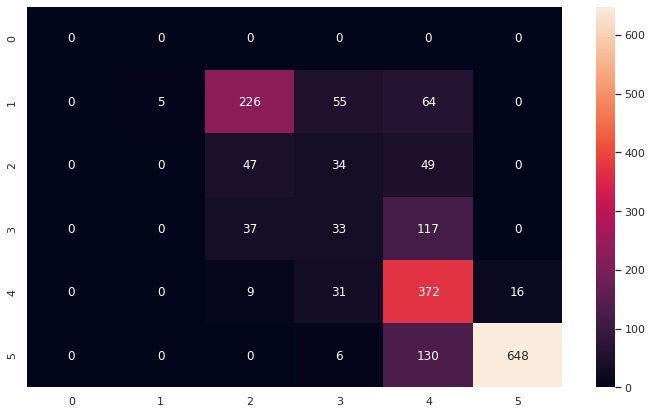

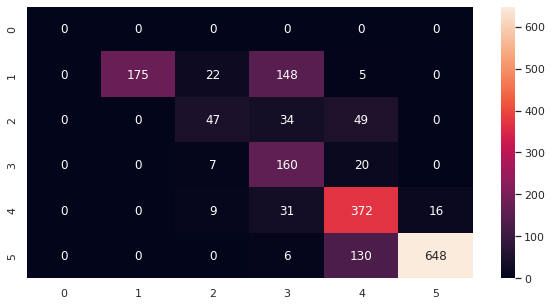

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.metrics import plot_confusion_matrix

labels = ['true','predicted']
conf_matrix = tf.math.confusion_matrix(
    df_preds['y_true'].values, 
    df_preds['y_pred'].values,
)

plt.figure(figsize = (10,5))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.show()


In [71]:
from sklearn.metrics import precision_score
print('total predictions', len(df_preds))
df_errors = df_preds[df_preds['y_true'] != df_preds['y_pred']]
print('total errors', len(df_errors))
print('accuracy score', accuracy_score(df_preds['y_true'], df_preds['y_pred']))
print(precision_score(df_preds['y_true'], df_preds['y_pred'],average='weighted'))

total predictions 1879
total errors 477
accuracy score 0.7461415646620543
0.8208366388354479
